## Librerias

In [136]:
from google.cloud import bigquery
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import random


import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [59]:
# Datos de las tablas a traer
proyecto = 'co-keralty-costomedico'
dataset = 'Diabetes_avicena_new'

# Nombres de tablas disponibles en el dataset
tables = ['diabetes', 'examenes_por_usuarios','antecedentes_x_usuario','perimetros_x_usuarios','actividadFisica_x_usuarios','diabetes_copy']

client_bq = bigquery.Client(project= proyecto)


tipo_identificacion = {
    'Cédula de ciudadanía' : 0,
    'Tarjeta de identidad' : 1,
    'Cédula de extranjería' : 2,
    'Permiso por Protección Temporal' : 3,
    'Pasaporte' : 4,
    'Permiso Especial de Permanencia' : 5,
    'Salvo Conducto de Permanencia' : 6,
}

nivel_academico = {
    'Básica secundaria' : 0,
    'Básica primaria' : 1,
    'Normalista' : 2,
    'Ninguno' : 3,
    'Profesional' : 4,
    'Técnica profesional' : 5,
    'Preescolar' : 6,
    'Bachillerato técnico' : 7,
    'Media académica o clásica' : 8,
    'Tecnológica' : 9,
    'Maestría' : 10,
    'Especialización' : 11,
    'Doctorado' : 12,
    'None' : 13,
}

raza_paciente = {
    'Otros' : 0,
    'Mestizo' : 1,
    'Raizales' : 2,
    'Afrocolombiano' : 3,
    'Indígena' : 4,
    'Palenquero' : 5,
    'Rom/Gitano' : 6,
    'None' : 7,
}

ejercicio = {
    '20 minutos\n' : 2,
    '40 minutos\n' : 1,
    'Nunca\n' : 3,
    '60 minutos\n' : 0,
}


## Funciones

In [60]:
def bring_data_from_bq(table, client_bq, query = '', save = False, read_local = False):

    print(f'Leyendo datos de la tabla: {table}')

    if query == '':
        query = f"""SELECT * FROM {proyecto}.{dataset}.{table} WHERE edad >= 18"""

    if read_local:
        data = pd.read_parquet(f'{table}.parquet')
    else:
        data = client_bq.query(query).result().to_dataframe()

        if save:
            data.to_parquet(f'{table}.parquet')
            print(f'Informacion guardada en el archivo: {table}.parquet')

    return data

def prepare_data(data):
    data_new = data.copy()

    campos = [['tipo_identificacion_paciente',tipo_identificacion],['nivel_academico_paciente',nivel_academico],['raza_paciente',raza_paciente],['hace_ejercicio',ejercicio]]

    for tupla in campos:
        data_new[tupla[0]] = data_new[tupla[0]].replace(tupla[1])

    data_new = data_new.drop(columns=['numero_identificacion_paciente','albuminuria']).astype(float)

    return data_new.drop_duplicates()

## Pesos Manuales

def peso_edad(value):
    if value < 45:
        return 0
    elif value < 54:
        return 1
    elif value <= 64:
        return 2
    else:
        return 3

def peso_imc(value):
    if value < 30:
        return 0
    elif value < 35:
        return 1
    elif value < 40:
        return 2
    else:
        return 3

def peso_pa(value, gender):

    if gender == 0:
        if value < 90:
            return 0
        elif value < 95:
            return 1
        else:
            return 2
    else:
        if value < 94:
            return 0
        elif value < 100:
            return 1
        else:
            return 2

def peso_ejercicio(value):
    if value == 2:
        return 2
    else:
        return 0

def peso_var_bivalente(value):
    if value == 1:
        return 2
    else:
        return 0

def peso_HDL(value):
    if value < 40:
        return 2
    elif value < 60:
        return 1
    else:
        return 0

def peso_LDL(value):
    if value < 130:
        return 0
    elif value < 160:
        return 1
    elif value < 190:
        return 2
    else:
        return 3

def peso_trigliceridos(value):
    if value < 150:
        return 0
    elif value < 200:
        return 1
    elif value < 500:
        return 2
    else:
        return 3

dict_variables = {
    'edad' : peso_edad,
    'imc' : peso_imc,
    'PERIMETRO_ABDOMINAL' : peso_pa,
    'hace_ejercicio' : peso_ejercicio,
    'med_hipertension' : peso_var_bivalente,
    'familiar_dm' : peso_var_bivalente,
    'HDL' : peso_HDL,
    'LDL' : peso_LDL,
    'trigliceridos' : peso_trigliceridos,
    'ant_cardiovascular' : peso_var_bivalente,
    'dm_gestacional' : peso_var_bivalente,
}

list(dict_variables.keys())

['edad',
 'imc',
 'PERIMETRO_ABDOMINAL',
 'hace_ejercicio',
 'med_hipertension',
 'familiar_dm',
 'HDL',
 'LDL',
 'trigliceridos',
 'ant_cardiovascular',
 'dm_gestacional']

## Carga de datos

In [61]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = True)
data = prepare_data(data_original)

data.head(5)

Leyendo datos de la tabla: diabetes


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,2.0,0.0
1,0.0,54.0,0.0,54001.0,1.0,0.0,57.6,1.5,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,2.0,0.0
2,0.0,69.0,0.0,15001.0,2.0,0.0,57.6,1.5,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,0.0,57.0,0.0,8001.0,3.0,0.0,57.6,1.5,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,2.0,1.0
4,0.0,50.0,0.0,19001.0,4.0,0.0,57.6,1.5,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,2.0,0.0


## Ajuste de Hiperparametros

In [62]:
random_grid = {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

### Mujeres

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
0,0.0,2,0.0,11001.0,0.0,0.0,57.6,1.50,0,1,0,0,0,0,0,0,0,0,0.0,3
1,0.0,2,0.0,54001.0,1.0,0.0,57.6,1.50,0,1,0,2,0,0,0,0,0,0,0.0,5
2,0.0,3,0.0,15001.0,2.0,0.0,57.6,1.50,0,0,2,0,0,0,0,0,0,0,0.0,5
3,0.0,2,0.0,8001.0,3.0,0.0,57.6,1.50,0,2,1,2,0,0,0,0,2,0,1.0,9
4,0.0,1,0.0,19001.0,4.0,0.0,57.6,1.50,0,1,1,1,0,0,0,0,0,0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292531,0.0,3,0.0,11001.0,0.0,0.0,68.5,1.42,1,2,0,0,2,0,2,0,2,2,0.0,14
292532,0.0,3,0.0,68001.0,1.0,0.0,68.5,1.42,1,2,3,2,2,0,2,0,2,0,1.0,17
292533,0.0,3,0.0,68001.0,1.0,0.0,68.5,1.42,1,2,3,2,2,0,2,0,2,0,1.0,17
292534,0.0,2,0.0,11001.0,8.0,0.0,68.9,1.49,1,0,1,0,2,0,2,0,2,2,0.0,12


Modelo entrenado con una precision de: 71.4
Modelo entrenado con f1 de: 0.39452541770351934


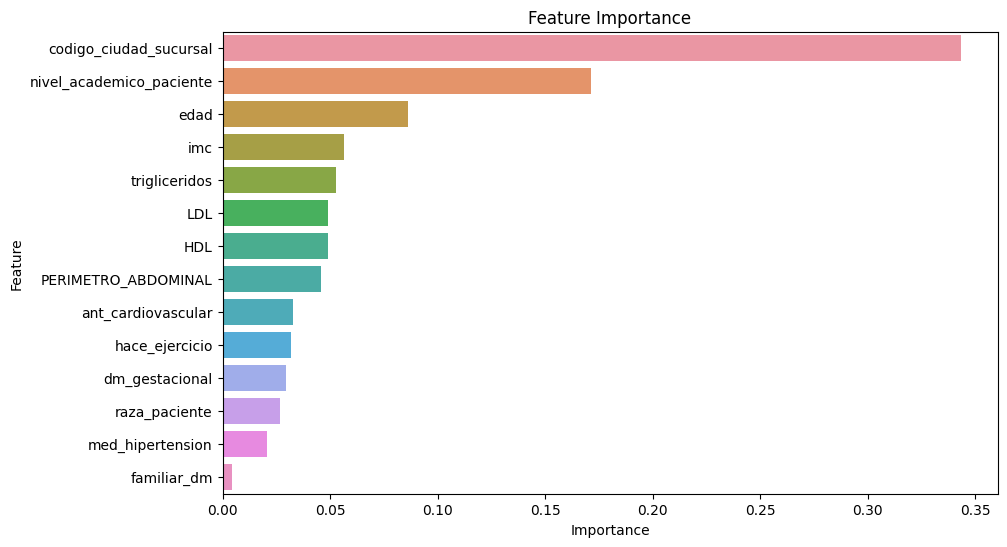

In [32]:
genero = 0
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      # 'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')


feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [23]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400]},
                   random_state=42)

In [24]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [25]:
model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 20, bootstrap = True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')

Modelo entrenado con una precision de: 73.62
Modelo entrenado con f1 de: 0.29991087344028516


### Hombres

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
6,0.0,1,1.0,41001.0,0.0,0.0,101.0,1.68,2,2,1,2,0,0,0,0,2,2,0.0,12
7,0.0,0,1.0,19001.0,0.0,1.0,101.0,1.68,2,1,0,0,0,0,0,0,2,2,0.0,7
24,1.0,0,1.0,20001.0,1.0,0.0,51.0,1.64,0,1,0,0,0,0,0,0,0,2,0.0,3
25,0.0,3,1.0,8758.0,3.0,0.0,83.3,1.75,0,1,0,1,0,0,0,0,1,0,0.0,6
105,0.0,1,1.0,19001.0,0.0,0.0,88.2,1.75,0,2,0,0,0,0,0,0,2,2,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.0,2,1.0,11001.0,2.0,0.0,94.6,1.73,1,1,0,2,2,0,2,0,2,2,0.0,14
292524,0.0,1,1.0,5001.0,0.0,0.0,94.6,1.73,1,1,2,2,2,0,2,0,2,0,0.0,13
292525,0.0,3,1.0,25307.0,3.0,0.0,94.6,1.73,1,1,0,0,2,0,2,0,2,2,1.0,13
292527,0.0,2,1.0,8001.0,5.0,0.0,99.1,1.81,1,1,0,0,2,0,2,0,1,0,0.0,9


Modelo entrenado con una precision de: 66.14
Modelo entrenado con f1 de: 0.42866271109082615


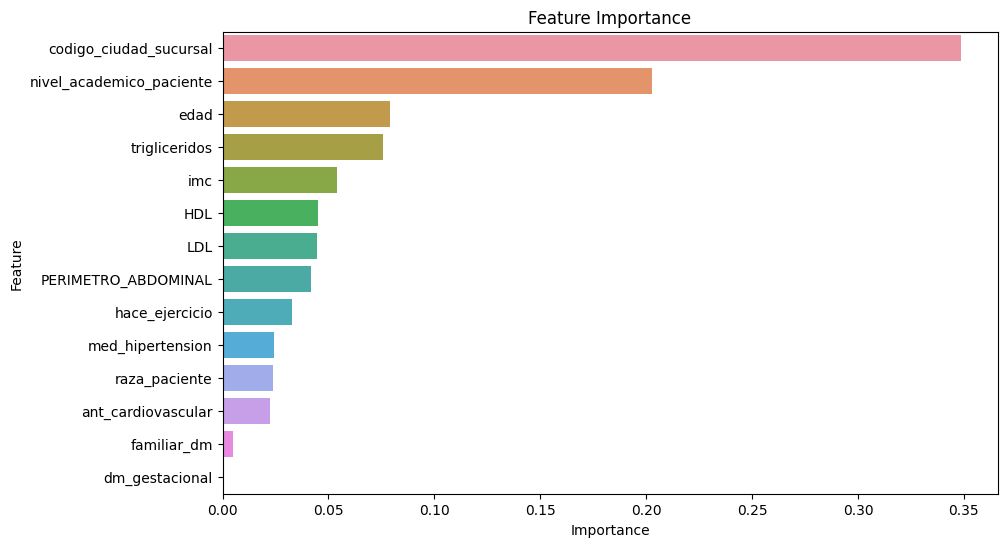

In [31]:
genero = 1
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      # 'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')


feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400]},
                   random_state=42)

In [29]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [30]:
model = RandomForestClassifier(n_estimators=200, min_samples_split = 2, min_samples_leaf = 4, max_features = 'auto', max_depth = 20, bootstrap = True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')

Modelo entrenado con una precision de: 68.63
Modelo entrenado con f1 de: 0.3544078361531612


### Ambos generos

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
3,0.0,2,0.0,8001.0,3.0,0.0,57.6,1.50,0,2,1,2,0,0,0,0,2,2,1.0,11
11,0.0,0,0.0,50001.0,0.0,0.0,101.0,1.68,2,1,0,2,0,0,0,2,2,0,1.0,9
21,0.0,0,0.0,11001.0,3.0,0.0,51.0,1.64,0,0,0,0,0,0,0,2,0,2,1.0,4
26,0.0,0,0.0,20001.0,4.0,0.0,61.2,1.50,0,1,0,0,0,0,0,0,0,0,1.0,1
31,0.0,0,0.0,20001.0,4.0,0.0,61.2,1.50,0,1,0,0,0,0,0,0,0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53841,0.0,0,1.0,5615.0,0.0,0.0,86.0,1.69,1,2,0,1,0,0,0,0,0,0,0.0,4
178632,0.0,2,1.0,54498.0,1.0,0.0,101.0,1.70,1,2,0,0,2,0,2,0,2,0,0.0,11
287579,0.0,1,1.0,47001.0,0.0,0.0,92.8,1.72,1,1,0,2,2,0,2,0,2,0,0.0,11
28550,0.0,0,1.0,8001.0,9.0,0.0,97.7,1.80,1,2,0,0,0,0,0,0,2,0,0.0,5


Modelo entrenado con una precision de: 63.44
Modelo entrenado con f1 de: 0.6381734414579826


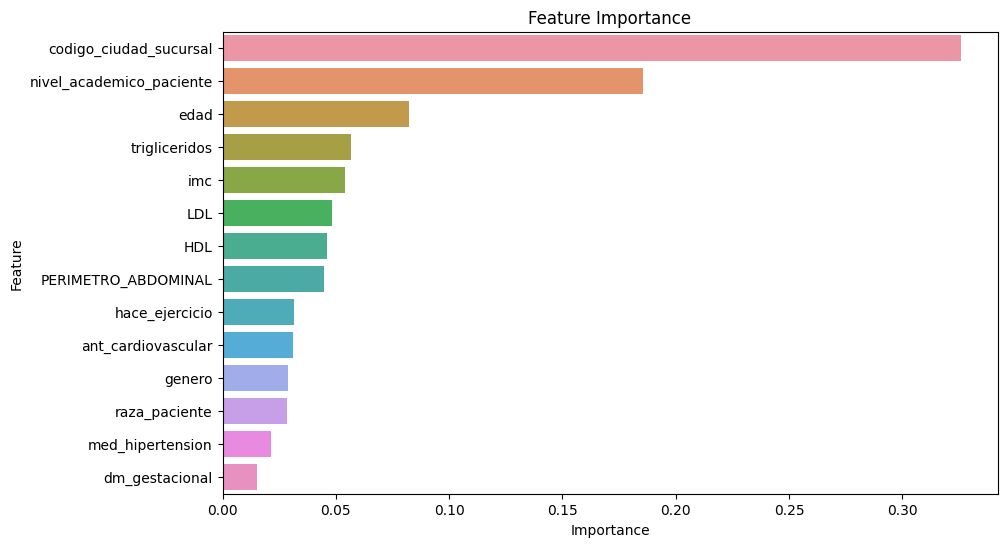

In [63]:
data_prueba = data[data.genero == 0].copy()
data_prueba_ = data[data.genero == 1].copy()

data_prueba['PERIMETRO_ABDOMINAL'] = data_prueba['PERIMETRO_ABDOMINAL'].map(lambda x: dict_variables['PERIMETRO_ABDOMINAL'](x, 0))
data_prueba_['PERIMETRO_ABDOMINAL'] = data_prueba_['PERIMETRO_ABDOMINAL'].map(lambda x: dict_variables['PERIMETRO_ABDOMINAL'](x, 1))
data_prueba = pd.concat([data_prueba,data_prueba_])

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        continue #data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                    #   'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


model = RandomForestClassifier(n_estimators=20)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

dict_sex = {0 : 'Mujeres', 1: 'Hombres'}

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')


feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [34]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400]},
                   random_state=42)

In [175]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
0,2,0.0,11001.0,0,1,0,0,0,0,0,0,0,2,0.0,0.0
1,2,0.0,54001.0,0,1,0,2,0,0,0,0,0,2,1.0,0.0
2,3,0.0,15001.0,0,0,2,0,0,0,0,0,0,0,2.0,0.0
3,2,0.0,8001.0,0,2,1,2,0,0,0,0,2,2,3.0,0.0
4,1,0.0,19001.0,0,1,1,1,0,0,0,0,0,2,4.0,0.0


Las variables mas relevantes en el entrenamiento del modelo son


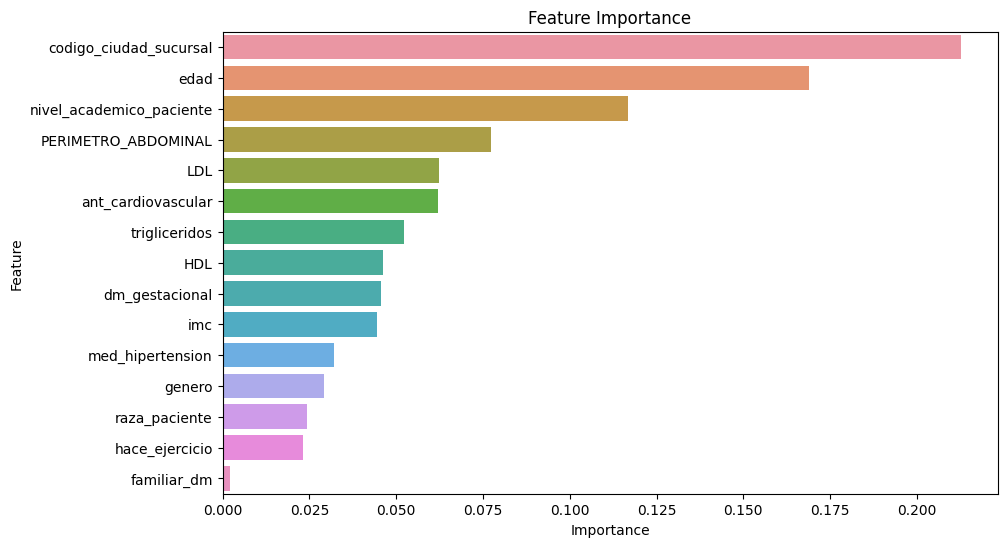

Modelo entrenado con una precision de: 72.11
Modelo entrenado con f1 de: 0.32034938025395704
La matriz de confusion es:


,0,1
0,63266,4269
1,22654,6345


Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion de tener diabetes es de: 6.28%
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
49972,0.0,53.0,0.0,8001.0,3.0,0.0,68.0,1.58,27.239224,56.0,103.0,112.0,1.0,0.0,0.0,0.0,80.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion de tener diabetes es de: 28.41%
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
9007,0.0,57.0,1.0,5001.0,0.0,0.0,85.3,1.67,30.585536,49.48,223.0,151.6,0.0,0.0,0.0,0.0,113.0,1.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion de tener diabetes es de: 15.57%
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
75774,0.0,62.0,0.0,19001.0,4.0,0.0,63.0,1.57,25.558846,39.8,114.8,248.0,0.0,0.0,0.0,0.0,98.0,1.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion de tener diabetes es de: 1.19%
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
68810,0.0,24.0,0.0,20001.0,5.0,1.0,34.7,1.52,15.019044,78.8,148.3,76.1,0.0,0.0,0.0,0.0,68.0,3.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion de tener diabetes es de: 17.51%
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
287817,0.0,54.0,0.0,11001.0,4.0,0.0,61.0,1.565,24.905838,57.0,109.0,193.0,1.0,0.0,1.0,0.0,80.0,2.0,0.0


In [152]:
data_prueba = data[data.genero == 0].copy()
data_prueba_ = data[data.genero == 1].copy()

data_prueba['PERIMETRO_ABDOMINAL'] = data_prueba['PERIMETRO_ABDOMINAL'].map(lambda x: dict_variables['PERIMETRO_ABDOMINAL'](x, 0))
data_prueba_['PERIMETRO_ABDOMINAL'] = data_prueba_['PERIMETRO_ABDOMINAL'].map(lambda x: dict_variables['PERIMETRO_ABDOMINAL'](x, 1))
data_prueba = pd.concat([data_prueba,data_prueba_])

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        continue #data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 20, bootstrap = True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

print('Las variables mas relevantes en el entrenamiento del modelo son')

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

Datos usados en el entrenamiento


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
3,57.0,0.0,8001.0,25.600000,39.00,143.0,280.0,0.0,0.0,0.0,0.0,95.0,2.0,3.0,0.0
11,43.0,0.0,50001.0,35.785147,44.92,121.0,321.0,0.0,0.0,0.0,1.0,126.0,3.0,0.0,0.0
21,32.0,0.0,11001.0,18.961927,81.00,83.0,34.0,0.0,0.0,0.0,1.0,74.0,2.0,3.0,0.0
26,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,3.0,4.0,0.0
31,40.0,0.0,20001.0,27.200000,51.00,125.0,87.0,0.0,0.0,0.0,0.0,70.0,1.0,4.0,0.0


Las variables mas relevantes en el entrenamiento del modelo son


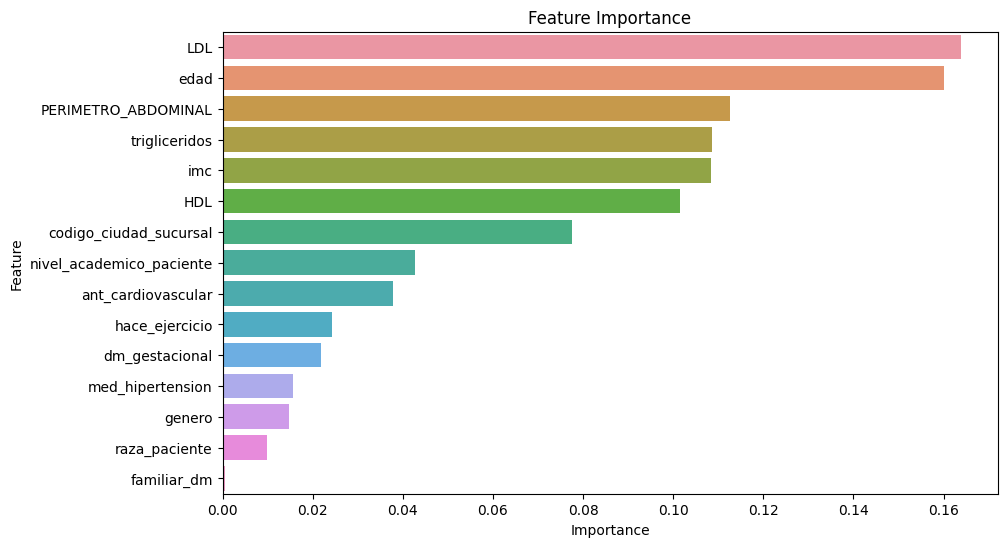

Modelo entrenado con una precision de: 70.01
Modelo entrenado con f1 de: 0.7109728038667175
La matriz de confusion es:


,0,1
0,19279,9929
1,7532,21476


Validacion con casos particulares 

--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 21.92%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
31308,0.0,25.0,0.0,11001.0,3.0,0.0,60.7,1.59,24.010126,50.0,97.5,119.7,0.0,0.0,0.0,0.0,68.0,0.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 31.64%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
32060,0.0,43.0,0.0,15001.0,7.0,0.0,86.0,1.57,34.889854,37.0,88.0,202.0,1.0,0.0,0.0,0.0,102.0,2.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 21.58%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
42150,2.0,40.0,0.0,19001.0,4.0,0.0,55.0,1.61,21.218317,62.4,81.0,46.7,0.0,0.0,0.0,0.0,70.0,0.0,0.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 41.54%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
194775,0.0,52.0,1.0,8001.0,1.0,0.0,65.4,1.64,24.315883,54.8,165.3,123.0,0.0,0.0,1.0,0.0,90.0,1.0,1.0


--------------------------------------------------------------------------------------------------------------------
La prediccion (en porcentaje) de tener diabetes es de: 42.76%
La prediccion (en categoria) de tener diabetes es de: 0.0
Los valores predichos son:


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
178962,0.0,67.0,1.0,41298.0,7.0,0.0,68.4,1.61,26.387871,51.0,104.0,63.0,1.0,0.0,1.0,0.0,92.0,3.0,0.0


In [155]:
df = data[data.diabetes == 1]

sample = data[data.diabetes == 0].sample(len(df))

df = pd.concat([df,sample]).dropna()

df_to_train = df[variables_to_train].copy()

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]

print('Datos usados en el entrenamiento')
display(X.head(5))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = RandomForestClassifier(n_estimators=200, min_samples_split = 5, min_samples_leaf = 4, max_features = 'auto', max_depth = 20, bootstrap = True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica = round(model.score(X_test, y_test)*100,2)
f1 = f1_score(y_test, y_pred)

print('Las variables mas relevantes en el entrenamiento del modelo son')

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

print(f'Modelo entrenado con una precision de: {metrica}')
print(f'Modelo entrenado con f1 de: {f1}')
print('La matriz de confusion es:')
display(pd.DataFrame(confusion_matrix(y_test, y_pred)))

print('Validacion con casos particulares \n')

for i in range(5):
    print('--------------------------------------------------------------------------------------------------------------------')
    row = random.choice(list(X_test.index))
    values = X_test.loc[[row]]
    meta = y_test.loc[[row]]
    indice = values.index[0]

    print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(values)[0][1]*100,2)}%')
    print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(values)[0]}')
    print(f'Los valores predichos son:')
    display(data.iloc[[indice]])

In [173]:
datos = {
    'edad' : [20],
    'genero' : [0],
    'codigo_ciudad_sucursal' : [11001],
    'imc' : [20],
    'HDL' : [70],
    'LDL' : [90],
    'trigliceridos' : [120],
    'med_hipertension' : [0],
    'familiar_dm' : [0],
    'ant_cardiovascular' : [0],
    'dm_gestacional' : [0],
    'PERIMETRO_ABDOMINAL' : [110],
    'hace_ejercicio' : [3],
    'nivel_academico_paciente' : [0],
    'raza_paciente' : [0],
}

temp = pd.DataFrame(datos)
display(temp)

,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
0,20,0,11001,20,70,90,120,0,0,0,0,110,3,0,0


In [174]:
print(f'La prediccion (en porcentaje) de tener diabetes es de: {round(model.predict_proba(temp)[0][1]*100,2)}%')
print(f'La prediccion (en categoria) de tener diabetes es de: {model.predict(temp)[0]}')

La prediccion (en porcentaje) de tener diabetes es de: 34.39%
La prediccion (en categoria) de tener diabetes es de: 0.0
